In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import xgboost as xgb

In [2]:
data = pd.read_csv("D:/AP/Data/CrossSell/Ins_train.csv")

In [3]:
replaceStruct = {
                "Vehicle_Age":     {"< 1 Year": 1, "1-2 Year": 2 ,"> 2 Years": 3},
                "Gender":     {"Female": 0, "Male": 1 },
                "Vehicle_Damage":     {"No": 0, "Yes": 1 } 
                    }

In [4]:
data = data.replace(replaceStruct)

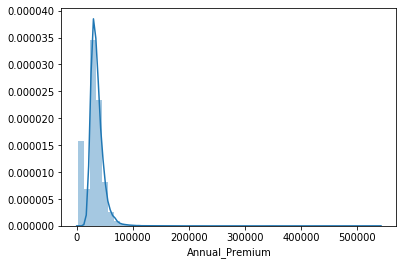

In [5]:
sns.distplot(data.Annual_Premium)

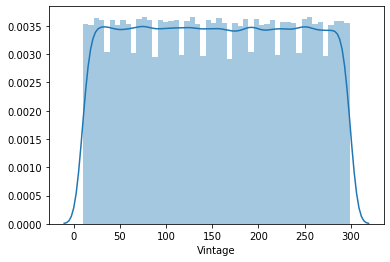

In [7]:
sns.distplot(data.Vintage)

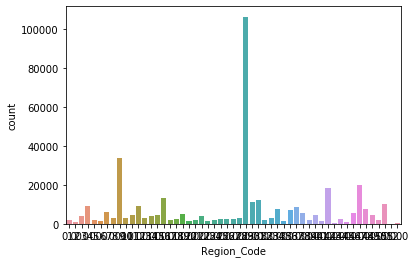

In [9]:
sns.countplot(data.Region_Code)

In [11]:
len(data.Region_Code.value_counts())

53

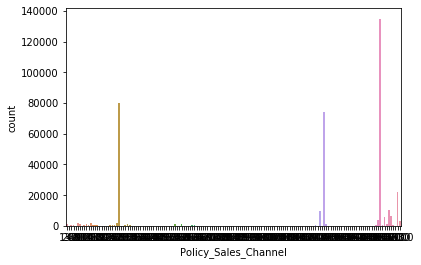

In [12]:
sns.countplot(data.Policy_Sales_Channel)

In [13]:
len(data.Policy_Sales_Channel.value_counts())

155

In [ ]:
sns.data.dri

In [6]:

data["Annual_Premium"] = np.where(data["Annual_Premium"] >100000, 100000.0,data['Annual_Premium'])

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
num_feat = ['Age','Annual_Premium','Vintage' ]

for column in num_feat:
    data[[column]] = sc.fit_transform(data[[column]])

In [14]:
from sklearn.preprocessing import LabelEncoder

cat_feat = ['Region_Code', 'Policy_Sales_Channel' ]
lb = LabelEncoder()
for column in cat_feat:
    data[column] = data[column].astype('str')
    data[column] = lb.fit_transform(data[column])

In [18]:
y = data['Response']
X = data[['Gender', 'Age', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)

In [26]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [29]:
xg = XGBClassifier(objective = 'binary:logistic', learning_rate=0.01, n_estimators=500, max_depth = 8,
            scale_pos_weight=3,nthread=8, colsample_bytree=0.6, subsample=0.6)

In [ ]:
#xg = XGBClassifier(objective = 'binary:logistic', learning_rate=0.05, n_estimators=250, max_depth = 8,
    #       scale_pos_weight=3,nthread=8, colsample_bytree=0.6, subsample=0.6)

In [27]:
xg_cv_score = cross_val_score(xg, x_train, y_train, cv = folds, verbose = 1, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.3min finished


In [28]:
print(xg_cv_score)
print("Mean accuracy:", np.mean(xg_cv_score))
print("Standard deviation", np.std(xg_cv_score))

[0.80161698 0.79861589 0.79654624 0.79626745 0.79900618]
Mean accuracy: 0.7984105474757011
Standard deviation 0.0019363197679138913


In [20]:
ev_set = [[x_train, y_train],[x_test, y_test]]

In [30]:
xg.fit(x_train, y_train, eval_metric="auc", eval_set=ev_set, verbose = 1,early_stopping_rounds = 10 )

[0]	validation_0-auc:0.841929	validation_1-auc:0.840302
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.850358	validation_1-auc:0.848075
[2]	validation_0-auc:0.851347	validation_1-auc:0.849089
[3]	validation_0-auc:0.851337	validation_1-auc:0.848997
[4]	validation_0-auc:0.854596	validation_1-auc:0.851461
[5]	validation_0-auc:0.853332	validation_1-auc:0.849478
[6]	validation_0-auc:0.853654	validation_1-auc:0.850009
[7]	validation_0-auc:0.854515	validation_1-auc:0.85131
[8]	validation_0-auc:0.854913	validation_1-auc:0.852029
[9]	validation_0-auc:0.854466	validation_1-auc:0.851723
[10]	validation_0-auc:0.854424	validation_1-auc:0.851833
[11]	validation_0-auc:0.854318	validation_1-auc:0.851739
[12]	validation_0-auc:0.854706	validation_1-auc:0.852136
[13]	validation_0-auc:0.85515	validation_1-auc:0.852322
[14]	validation_0-auc:0.854894	validation_1-auc:0.851847


XGBClassifier(colsample_bytree=0.6, learning_rate=0.01, max_depth=8,
              n_estimators=500, nthread=8, scale_pos_weight=3, subsample=0.6)

In [22]:
pred = xg.predict(x_test, ntree_limit = 97 )

In [23]:
confusion_matrix(y_test, pred)

array([[54008, 12889],
       [ 2762,  6563]], dtype=int64)

In [24]:
from sklearn.metrics import f1_score
print("Accuracy:",accuracy_score(y_test, pred))
print("Precision:",precision_score(y_test, pred))
print("Recall:",recall_score(y_test, pred))
print('F1-Score:',f1_score(y_test, pred))

Accuracy: 0.7946655821153997
Precision: 0.3373946123791898
Recall: 0.7038069705093833
F1-Score: 0.45612815790388156


In [68]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'eta':0.01,
    'n_estimators':500,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'max_delta_step' : 2,
    # Other parameters
    'objective':'binary:logistic'
}

In [69]:
dtrain = xgb.DMatrix(x_train, label=y_train)

In [70]:
cv_results = xgb.cv(params, dtrain, nfold=3, metrics = 'auc', verbose_eval=1)

[0]	train-auc:0.843923+0.000314658	test-auc:0.837618+0.00075762
[1]	train-auc:0.856165+0.00134262	test-auc:0.848229+0.00204718
[2]	train-auc:0.857301+0.00196842	test-auc:0.848279+0.00263354
[3]	train-auc:0.856575+0.00373043	test-auc:0.846577+0.00390573
[4]	train-auc:0.8583+0.00319768	test-auc:0.847943+0.003028
[5]	train-auc:0.85899+0.00294341	test-auc:0.848622+0.00201156
[6]	train-auc:0.85978+0.00321123	test-auc:0.849139+0.00249347
[7]	train-auc:0.861091+0.00199919	test-auc:0.850401+0.00171502
[8]	train-auc:0.860486+0.00177425	test-auc:0.850048+0.00189307
[9]	train-auc:0.860051+0.00186566	test-auc:0.849568+0.00215418


In [53]:
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.122600,0.000460,0.123721,0.001161
1,0.122324,0.000489,0.122809,0.000980
2,0.122353,0.000440,0.122747,0.000868
3,0.122359,0.000491,0.122718,0.000991
4,0.122429,0.000529,0.122652,0.000963
5,0.122465,0.000519,0.122652,0.000952
6,0.122499,0.000519,0.122662,0.000988
7,0.122542,0.000486,0.122655,0.000972
8,0.122514,0.000465,0.122649,0.000947
9,0.122516,0.000446,0.122629,0.000964
